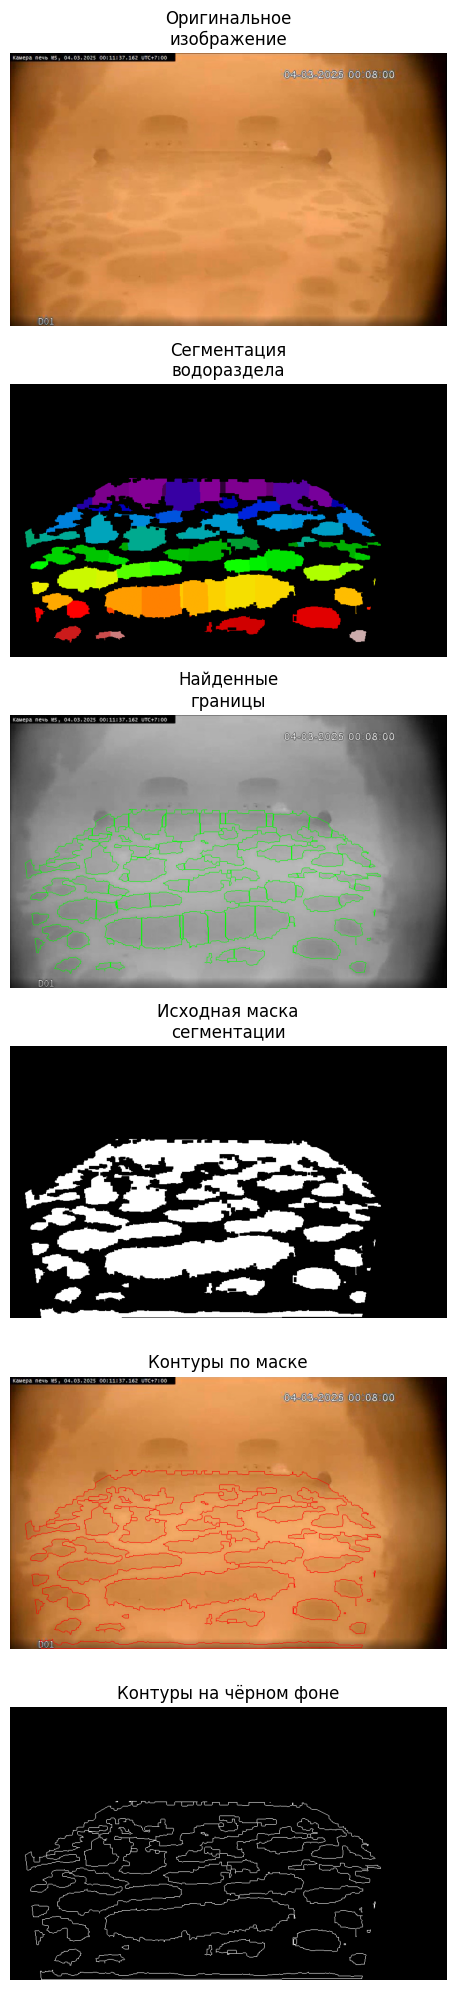

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# Функции морфологической обработки
def erode(img, k_s=3, it=1):
    kernel = np.ones((k_s, k_s), 'uint8')
    return cv2.erode(img, kernel, iterations=it)

def dilate(img, k_s=3, it=1):
    kernel = np.ones((k_s, k_s), 'uint8')
    return cv2.dilate(img, kernel, iterations=it)

def del_small_areas(thresh, area_black=300, area_white=10):
    result = morphology.remove_small_objects(label(thresh), area_white)
    result[result > 0] = 255
    result = morphology.remove_small_objects(label(255 - result), area_black)
    result[result > 0] = 255
    return (255 - result).astype(np.uint8)  # Приведение к uint8

# Загрузка изображения
img = cv2.imread('data/Pyatna2.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('data/Pyatna2.jpg')
img2 = cv2.resize(img2, (813, 508))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (813, 508))
height, width = img.shape

# Задаём полигон
polygon_vertices = np.array([
    [50, 505],
    [677, 505],
    [708, 290],
    [543, 188],
    [194, 181],
    [47, 250]
], np.int32)

# Задаём полигон
polygon_vertices2 = np.array([
    [58, 507],
    [654, 505],
    [698, 257],
    [547, 178],
    [198, 175],
    [28, 275]
], np.int32)

# Создаём маску полигона
polygon_mask = np.zeros((height, width), dtype=np.uint8)
# cv2.fillPoly(polygon_mask, [polygon_vertices], 255)
cv2.fillPoly(polygon_mask, [polygon_vertices2], 255)

# Выделяем маску на изображении
thresh_local_1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 151, 0)
thresh_local = del_small_areas(erode(dilate(thresh_local_1)))
thresh_local = cv2.morphologyEx(thresh_local, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

# Оставляем только область внутри полигона
thresh_local = cv2.bitwise_and(thresh_local, polygon_mask)

cnts2, _ = cv2.findContours(thresh_local, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = img2.copy()
cv2.drawContours(image_with_contours, cnts2, -1, (255, 0, 0), 1)

distance = ndi.distance_transform_edt(thresh_local)
local_max = peak_local_max(distance, min_distance=30, footprint=np.ones((3, 3)), labels=thresh_local)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(local_max.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=thresh_local)

image_countours =cv2.cvtColor(img.copy(),cv2.COLOR_GRAY2BGR)
for label in np.unique(labels):
    if label == 0:
        continue
    mask = np.zeros(thresh_local.shape, dtype="uint8")
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cv2.drawContours(image_countours, cnts, -1, (0,255,0), 1)

# Отображение контуров на черном фоне
blank = np.zeros_like(thresh_local)  # черное изображение того же размера
cv2.drawContours(blank, cnts2, -1, 255, 1)  # белые контуры (цвет = 255, толщина = 1)

fig, axes = plt.subplots(nrows=6, figsize=(40, 20), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(img2)
ax[0].set_title('Оригинальное\nизображение')
ax[1].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Сегментация\nводораздела')
ax[2].imshow(image_countours, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Найденные\nграницы')
ax[3].imshow(thresh_local, cmap=plt.cm.gray)
ax[3].set_title('Исходная маска\nсегментации')
ax[4].imshow(image_with_contours)
ax[4].set_title('Контуры по маске')
ax[5].imshow(blank, cmap='gray')
ax[5].set_title('Контуры на чёрном фоне')

for a in ax:
    a.set_axis_off()
fig.tight_layout()
plt.show()


In [3]:
height, width = img.shape

In [4]:
print(height, width)

508 813
